## Multi-class Classification with Prompt Engineering

### 1.0 Context and Outcomes

#### 1.1 Session Objective

The objective of this session is to learn how to do multi-class classification using few shot prompts on a banking dataset with the outcome of identifying a customer's intent using their query text

For the purpose of this demonstration, we will be using the a hugging face dataset called **banking77** from their dataset repository.

#### 1.2 Understanding the dataset

Explore the dataset at https://huggingface.co/datasets/PolyAI/banking77

There are a total of 77 classes or intents which have been defined. For the purpose of learning, we will pick a few classes which are related to credit card top-ups

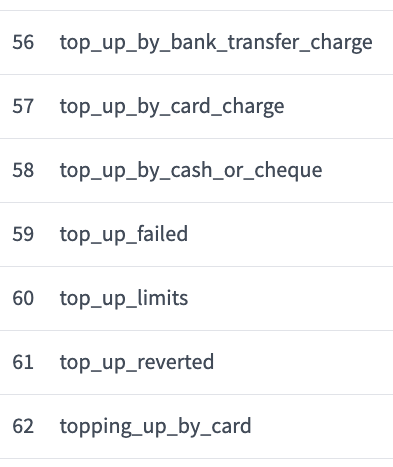

### 2.0 Getting setup with Azure OpenAI

#### 2.1 Importing necessary libraries

In [9]:
%pip install openai==0.28 tiktoken datasets session-info --quiet

Note: you may need to restart the kernel to use updated packages.


In [10]:
# Import all Python packages required to access the Azure Open AI API.
# Import additional packages required to access datasets and create examples.

import os
import openai
import json
import random
import tiktoken
import session_info

import pandas as pd
import numpy as np

from datasets import load_dataset
from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from datasets import load_dataset, list_datasets

import time

In [11]:
session_info.show()

#### 2.2 OpenAI Authentication

In [12]:
openai.api_key = os.environ["AZURE_OPENAI_KEY"]
openai.api_base = os.environ["AZURE_OPENAI_BASE"]
openai.api_type = os.environ["AZURE_OPENAI_APITYPE"]
openai.api_version = os.environ["AZURE_OPENAI_APIVERSION"]
chat_model_id = os.environ["GPT_MODEL"]

### 3.0 All function definitions

#### 3.1 Get number of tokens for a prompt

In [13]:
def num_tokens_from_messages(messages):

    """
    Return the number of tokens used by a list of messages.
    Adapted from the Open AI cookbook token counter
    """

    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

    # Each message is sandwiched with <|start|>role and <|end|>
    # Hence, messages look like: <|start|>system or user or assistant{message}<|end|>

    tokens_per_message = 3 # token1:<|start|>, token2:system(or user or assistant), token3:<|end|>

    num_tokens = 0

    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))

    num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>

    return num_tokens

#### 3.2 Create a few shot prompt

In [14]:
def create_prompt(system_message, examples, user_message_template):

    """
    Return a prompt message in the format expected by the Open AI API.
    Loop through the examples and parse them as user message and assistant
    message.

    Args:
        system_message (str): system message with instructions for sentiment analysis
        examples (str): JSON string with list of examples
        user_message_template (str): string with a placeholder for movie reviews

    Output:
        few_shot_prompt (List): A list of dictionaries in the Open AI prompt format
    """

    few_shot_prompt = [{'role':'system', 'content': system_message}]

    for example in json.loads(examples):
        example_text = example['text']
        example_label = example['label']

        few_shot_prompt.append(
            {
                'role': 'user',
                'content': user_message_template.format(
                    text=example_text
                )
            }
        )

        few_shot_prompt.append(
            {'role': 'assistant', 'content': f"{example_label}"}
        )

    return few_shot_prompt

#### 3.3 Get customer intent

In [15]:
def get_intent(prompt, user_input):
    response = openai.ChatCompletion.create(
                deployment_id=chat_model_id,
                messages=prompt+user_input,
                temperature=0,
                max_tokens=6
    )

    prediction = response['choices'][0]['message']['content']

    return prediction

### 4.0 Getting setup with the data

Let's read the banking77 dataset into a variable

In [16]:
banking_corpus = load_dataset("PolyAI/banking77")

In [17]:
banking_corpus

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})

Convert the training data into a pandas dataframe and filter only for the top-up classes / intents

In [18]:
banking_train_df = banking_corpus['train'].to_pandas()

In [19]:
banking_train_df = banking_train_df[banking_train_df['label'].isin([56,57,58,59,60,61,62])]

In [20]:
banking_train_df.head()

,text,label
1817,Is there a top up fee for transfer?,56
1818,Will there be a charge for topping up by accou...,56
1819,What are the charges for receiving a SEPA tran...,56
1820,Is there a charge for SEPA transfers?,56
1821,Will I be charged a fee for a SEPA transfer?,56


In [21]:
banking_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 830 entries, 1817 to 9178
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    830 non-null    object
 1   label   830 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 19.5+ KB


In [22]:
banking_train_df.label.value_counts()

label
61    146
59    145
58    114
57    114
56    111
62    103
60     97
Name: count, dtype: int64

#### 4.0 Splitting the data into examples and gold_examples

In [23]:
banking_examples_df, banking_gold_examples_df = train_test_split(
    banking_train_df, #<- the full dataset
    test_size=0.2, #<- 20% random sample selected for gold examples
    random_state=1 #<- ensures that the splits are the same for every session
)

In [24]:
(banking_examples_df.shape, banking_gold_examples_df.shape)

((664, 2), (166, 2))

In [25]:
gold_examples = (
        banking_gold_examples_df.sample(10, random_state=1) #<- ensures that gold examples are the same for every session
                                     .to_json(orient='records')
)

In [26]:
json.loads(gold_examples)

[{'text': 'What is the charge to make a transfer', 'label': 56},
 {'text': 'I topped off my card is that something you will charge me for?',
  'label': 57},
 {'text': 'The money disappeared when I tried to use my card to top up.',
  'label': 62},
 {'text': "My top-up didn't work.", 'label': 59},
 {'text': "I don't understanfd how to top up", 'label': 62},
 {'text': "Are their fee's for top ups?", 'label': 57},
 {'text': 'Are there any charges for top ups?', 'label': 57},
 {'text': "Why can't I see my top up?", 'label': 62},
 {'text': 'What are the charges for topping up US card?', 'label': 57},
 {'text': 'Will there be extra charges regarding to adding money into my international card?',
  'label': 57}]

### 5.0 Creating and testing prompts

#### 5.1 Creating a Zero shot prompt

In [27]:
user_message_template = """```{text}```"""

In [28]:
zero_shot_system_message = """
Your task is to classify this ```{text}``` provided into a customer's intent

Below is a list of customer intents along with their intent codes separated by a ":"

top_up_by_bank_transfer_charge:56
top_up_by_card_charge:57
top_up_by_cash_or_cheque:58
top_up_failed:59
top_up_limits:60
top_up_reverted:61
topping_up_by_card:62

After you classify, strictly output only one intent code
"""

In [29]:
zero_shot_prompt = [{'role':'system', 'content': zero_shot_system_message}]

In [30]:
num_tokens_from_messages(zero_shot_prompt)

108

#### 5.2 Testing the zero shot prompt

In [31]:
for example in json.loads(gold_examples):
  gold_input = example['text']
  user_input = [{'role':'user','content': user_message_template.format(text=gold_input)}]
  print(get_intent(zero_shot_prompt,user_input))
  print(example['label'])
  time.sleep(2)

Intent Code: 56 (
56
Intent Code: 62 (
57
Intent code: 59 (
62
Intent Code: 59 (
59
Intent code: 59 (
62
The customer's intent is top
57
Intent Code: 56 (
57
Intent code: 59 (
62
Intent Code: 57 (
57
Intent code: 56 (
57


In [32]:
for example in json.loads(gold_examples):
  gold_input = example['text']
  user_input = [{'role':'user','content': user_message_template.format(text=gold_input)}]
  print(get_intent(zero_shot_prompt,user_input))
  print(example['label'])
  time.sleep(11)

Intent Code: 56 (
56
Intent Code: 62 (
57
Intent code: 59 (
62
Intent Code: 59 (
59
Intent code: 59 (
62
The customer's intent is top
57
Intent Code: 56 (
57
Intent code: 59 (
62
Intent Code: 57 (
57
Intent code: 56 (
57


#### 5.3 Creating a Few shot prompt

In [33]:
few_shot_system_message = """
Your task is to classify this ```{text}``` provided into a customer's intent

Below is a list of customer intents along with their intent codes separated by a ":"

top_up_by_bank_transfer_charge:56
top_up_by_card_charge:57
top_up_by_cash_or_cheque:58
top_up_failed:59
top_up_limits:60
top_up_reverted:61
topping_up_by_card:62

After you classify, strictly output only one intent code
"""

In [34]:
code_56 = (banking_examples_df.label == 56)
code_57 = (banking_examples_df.label == 57)
code_58 = (banking_examples_df.label == 58)
code_59 = (banking_examples_df.label == 59)
code_60 = (banking_examples_df.label == 60)
code_61 = (banking_examples_df.label == 61)
code_62 = (banking_examples_df.label == 62)

In [ ]:
code_56

1921     True
2298    False
3170    False
1874     True
9079    False
        ...  
8612    False
9116    False
1889     True
3182    False
1854     True
Name: label, Length: 664, dtype: bool

In [35]:
code_56_examples = banking_examples_df.loc[code_56, ['text','label']].sample(6)
code_57_examples = banking_examples_df.loc[code_57, ['text','label']].sample(6)
code_58_examples = banking_examples_df.loc[code_58, ['text','label']].sample(6)
code_59_examples = banking_examples_df.loc[code_59, ['text','label']].sample(6)
code_60_examples = banking_examples_df.loc[code_60, ['text','label']].sample(6)
code_61_examples = banking_examples_df.loc[code_61, ['text','label']].sample(6)
code_62_examples = banking_examples_df.loc[code_62, ['text','label']].sample(6)

In [36]:
code_56_examples

,text,label
1850,Is there a fee to make a transfer?,56
1845,What are the fees associated with top up via t...,56
1905,Do I get charged if I am receiving money?,56
1895,How much does it cost to make transfers?,56
1919,"If I top up by transfer, am I going to be char...",56
1868,Are SWIFT Transfers available at this bank?,56


In [37]:
examples = pd.concat([code_56_examples, code_57_examples, code_58_examples, code_59_examples, code_60_examples, code_61_examples, code_62_examples])

In [38]:
randomized_examples = examples.sample(42, replace=False)

In [39]:
examples = randomized_examples.to_json(orient='records')

In [40]:
examples

'[{"text":"What is the top-up limit on my cards?","label":60},{"text":"Do you accept cheques for top-up?","label":58},{"text":"What are the fees associated with top up via transfer?","label":56},{"text":"how much is the fee for topping by card","label":57},{"text":"My credit card was declined for top-up. Can you see if there is enough funds in my account?","label":59},{"text":"I have a canceled top-up and wanted to know about it.","label":61},{"text":"What is the Top up rate charge for using a card in the US?","label":57},{"text":"Is there a fee for topping up by charge card?","label":57},{"text":"Are there any top-up limits involved?","label":60},{"text":"Are SWIFT Transfers available at this bank?","label":56},{"text":"What is the maximum for top-ups?","label":60},{"text":"I used my card to top up, but now I don\'t see the money in my account.","label":62},{"text":"is there a limit on top ups","label":60},{"text":"I need help reapplying my top-up. It seems it isn\'t working.","label"

In [41]:
few_shot_prompt = create_prompt(
    few_shot_system_message,
    examples,
    user_message_template
)

In [42]:
few_shot_prompt

[{'role': 'system',
  'content': '\nYour task is to classify this ```{text}``` provided into a customer\'s intent\n\nBelow is a list of customer intents along with their intent codes separated by a ":"\n\ntop_up_by_bank_transfer_charge:56\ntop_up_by_card_charge:57\ntop_up_by_cash_or_cheque:58\ntop_up_failed:59\ntop_up_limits:60\ntop_up_reverted:61\ntopping_up_by_card:62\n\nAfter you classify, strictly output only one intent code\n'},
 {'role': 'user', 'content': '```What is the top-up limit on my cards?```'},
 {'role': 'assistant', 'content': '60'},
 {'role': 'user', 'content': '```Do you accept cheques for top-up?```'},
 {'role': 'assistant', 'content': '58'},
 {'role': 'user',
  'content': '```What are the fees associated with top up via transfer?```'},
 {'role': 'assistant', 'content': '56'},
 {'role': 'user', 'content': '```how much is the fee for topping by card```'},
 {'role': 'assistant', 'content': '57'},
 {'role': 'user',
  'content': '```My credit card was declined for top-up

#### 5.4 Testing the Few shot prompt

In [43]:
for example in json.loads(gold_examples):
  gold_input = example['text']
  user_input = [{'role':'user','content': user_message_template.format(text=gold_input)}]
  print(f"Predicted intent: {get_intent(few_shot_prompt,user_input)}")
  print(f"Real intent: {example['label']}")
  time.sleep(11)

Predicted intent: 56
Real intent: 56
Predicted intent: 57
Real intent: 57
Predicted intent: 62
Real intent: 62
Predicted intent: 59
Real intent: 59
Predicted intent: 62
Real intent: 62
Predicted intent: 57
Real intent: 57
Predicted intent: 57
Real intent: 57
Predicted intent: 62
Real intent: 62
Predicted intent: 57
Real intent: 57
Predicted intent: 57
Real intent: 57
